In [1]:
#invite people for the Kaggle party
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import seaborn as sns
from sklearn import ensemble, tree, linear_model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import shuffle
import xgboost as xgb 


plt.rcParams['font.family']='DFKai-SB' #顯示中文(for Win10)
plt.rcParams['axes.unicode_minus']=False #正常顯示負號
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


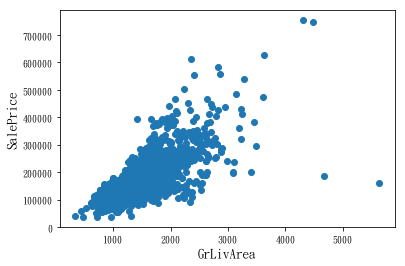

In [2]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

In [3]:
#Deleting outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

In [4]:
# Prints R2 and RMSE scores
def get_score(prediction, lables):    
    print('R2: {}'.format(r2_score(prediction, lables)))
    print('RMSE: {}'.format(np.sqrt(mean_squared_error(prediction, lables))))

# Shows scores for train and validation sets    
def train_test(estimator, x_trn, x_tst, y_trn, y_tst):
    prediction_train = estimator.predict(x_trn)
    # Printing estimator
    print(estimator)
    # Printing train scores
    get_score(prediction_train, y_trn)
    prediction_test = estimator.predict(x_tst)
    # Printing test scores
    print("Test")
    get_score(prediction_test, y_tst)

In [5]:
# Spliting to features and lables and deleting variable I don't need
train_labels = train.pop('SalePrice')
features = pd.concat([train, test], keys=['train', 'test'])

In [6]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [7]:
#missing data
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1452,0.995885
MiscFeature,1404,0.962963
Alley,1367,0.937586
Fence,1177,0.807270
FireplaceQu,690,0.473251
LotFrontage,259,0.177641
GarageCond,81,0.055556
GarageType,81,0.055556
GarageYrBlt,81,0.055556
GarageFinish,81,0.055556


In [8]:
# Spliting to features and lables and deleting variable I don't need

# I decided to get rid of features that have more than half of missing information or do not correlate to SalePrice
features.drop(['Utilities', 'RoofMatl', 'MasVnrArea', 'Heating', 'LowQualFinSF', 'WoodDeckSF',
               'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'],
              axis=1, inplace=True)

In [9]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [10]:

features["PoolQC"] = features["PoolQC"].fillna("None")
features["MiscFeature"] = features["MiscFeature"].fillna("None")
features["Fence"] = features["Fence"].fillna("None")

for col in ('GarageYrBlt', 'GarageArea', 'GarageCond'):
    features[col] = features[col].fillna(0)

for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'BsmtFullBath', 'BsmtHalfBath'):
    features[col] = features[col].fillna(0)
    
features["Functional"] = features["Functional"].fillna("Typ")
     
# MSSubClass as str
features['MSSubClass'] = features['MSSubClass'].astype(str)

# MSZoning NA in pred. filling with most popular values
features['MSZoning'] = features['MSZoning'].fillna(features['MSZoning'].mode()[0])

# LotFrontage  NA in all. I suppose NA means 0
features['LotFrontage'] = features['LotFrontage'].fillna(features['LotFrontage'].mean())

# Alley  NA in all. NA means no access
features['Alley'] = features['Alley'].fillna('NOACCESS')

# Converting OverallCond to str
features.OverallCond = features.OverallCond.astype(str)

# MasVnrType NA in all. filling with most popular values
features['MasVnrType'] = features['MasVnrType'].fillna(features['MasVnrType'].mode()[0])

# BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2
# NA in all. NA means No basement
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    features[col] = features[col].fillna('NoBSMT')

# TotalBsmtSF  NA in pred. I suppose NA means 0
features['TotalBsmtSF'] = features['TotalBsmtSF'].fillna(0)


# Electrical NA in pred. filling with most popular values
features['Electrical'] = features['Electrical'].fillna(features['Electrical'].mode()[0])

# KitchenAbvGr to categorical
features['KitchenAbvGr'] = features['KitchenAbvGr'].astype(str)

# KitchenQual NA in pred. filling with most popular values
features['KitchenQual'] = features['KitchenQual'].fillna(features['KitchenQual'].mode()[0])

# FireplaceQu  NA in all. NA means No Fireplace
features['FireplaceQu'] = features['FireplaceQu'].fillna('NoFP')

# GarageType, GarageFinish, GarageQual  NA in all. NA means No Garage
for col in ('GarageType', 'GarageFinish', 'GarageQual'):
    features[col] = features[col].fillna('NoGRG')

# GarageCars  NA in pred. I suppose NA means 0
features['GarageCars'] = features['GarageCars'].fillna(0.0)

# SaleType NA in pred. filling with most popular values
features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])

# Year and Month to categorical
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)

# Adding total sqfootage feature and removing Basement, 1st and 2nd floor features
features['TotalSF'] = features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']
features.drop(['TotalBsmtSF', '1stFlrSF', '2ndFlrSF'], axis=1, inplace=True)


In [11]:
from scipy import stats
from scipy.stats import norm, skew #for some statistics
numeric_feats = features.dtypes[features.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = features[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
LotArea,13.109495
BsmtFinSF2,4.144503
BsmtHalfBath,3.929996
LotFrontage,1.228305
GrLivArea,1.068750
TotalSF,1.009157
BsmtFinSF1,0.980645
BsmtUnfSF,0.919688
TotRmsAbvGrd,0.749232
Fireplaces,0.725278


In [12]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #features[feat] += 1
    features[feat] = boxcox1p(features[feat], lam)
    
# features[skewed_features] = np.log1p(features[skewed_features])

There are 21 skewed numerical features to Box Cox transform


In [13]:
## Standardizing numeric features
numeric_features = train.loc[:,['LotFrontage', 'LotArea', 'GrLivArea', 'TotalSF']]
numeric_features_standardized = (numeric_features - numeric_features.mean())/numeric_features.std()


In [14]:
# Getting Dummies from Condition1 and Condition2
conditions = set([x for x in features['Condition1']] + [x for x in features['Condition2']])
dummies = pd.DataFrame(data=np.zeros((len(features.index), len(conditions))),
                       index=features.index, columns=conditions)
for i, cond in enumerate(zip(features['Condition1'], features['Condition2'])):
    dummies.ix[i, cond] = 1
features = pd.concat([features, dummies.add_prefix('Condition_')], axis=1)
features.drop(['Condition1', 'Condition2'], axis=1, inplace=True)


In [15]:
# Getting Dummies from Exterior1st and Exterior2nd
exteriors = set([x for x in features['Exterior1st']] + [x for x in features['Exterior2nd']])
dummies = pd.DataFrame(data=np.zeros((len(features.index), len(exteriors))),
                       index=features.index, columns=exteriors)
for i, ext in enumerate(zip(features['Exterior1st'], features['Exterior2nd'])):
    dummies.ix[i, ext] = 1
features = pd.concat([features, dummies.add_prefix('Exterior_')], axis=1)
features.drop(['Exterior1st', 'Exterior2nd'], axis=1, inplace=True)


In [16]:
# Getting Dummies from all other categorical vars
for col in features.dtypes[features.dtypes == 'object'].index:
    for_dummy = features.pop(col)
    features = pd.concat([features, pd.get_dummies(for_dummy, prefix=col)], axis=1)

In [17]:
### Copying features
features_standardized = features.copy()

### Replacing numeric features by standardized values
features_standardized.update(numeric_features_standardized)

In [18]:
### Splitting features
train_features = features.loc['train'].drop('Id', axis=1).select_dtypes(include=[np.number]).values
test_features = features.loc['test'].drop('Id', axis=1).select_dtypes(include=[np.number]).values

In [19]:
train_features

array([[ 5.83132789, 19.21218231,  2.44026838, ...,  0.        ,
         1.        ,  0.        ],
       [ 6.22121363, 19.71220478,  2.25967379, ...,  0.        ,
         1.        ,  0.        ],
       [ 5.91494002, 20.34724091,  2.44026838, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 5.85955121, 19.47634523,  2.44026838, ...,  0.        ,
         1.        ,  0.        ],
       [ 5.91494002, 19.76017576,  2.05564154, ...,  0.        ,
         1.        ,  0.        ],
       [ 6.0986261 , 19.84906344,  2.05564154, ...,  0.        ,
         1.        ,  0.        ]])

In [20]:

### Splitting standardized features
train_features_st = features_standardized.loc['train'].drop('Id', axis=1).select_dtypes(include=[np.number]).values
test_features_st = features_standardized.loc['test'].drop('Id', axis=1).select_dtypes(include=[np.number]).values

In [21]:
### Shuffling train sets
train_features_st, train_features, train_labels = shuffle(train_features_st, train_features, train_labels, random_state = 5)

In [22]:
### Splitting
x_train, x_test, y_train, y_test = train_test_split(train_features, train_labels, test_size=0.1, random_state=200)
x_train_st, x_test_st, y_train_st, y_test_st = train_test_split(train_features_st, train_labels, test_size=0.1, random_state=200)

In [23]:
# Prints R2 and RMSE scores
def get_score(prediction, lables):    
    print('R2: {}'.format(r2_score(prediction, lables)))
    print('RMSE: {}'.format(np.sqrt(mean_squared_error(prediction, lables))))

# Shows scores for train and validation sets    
def train_test(estimator, x_trn, x_tst, y_trn, y_tst):
    prediction_train = estimator.predict(x_trn)
    # Printing estimator
    print(estimator)
    # Printing train scores
    get_score(prediction_train, y_trn)
    prediction_test = estimator.predict(x_tst)
    # Printing test scores
    print("Test")
    get_score(prediction_test, y_tst)

In [24]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(x_train_st)
train_features = sc.transform(x_train_st)

In [25]:
import numpy as np
train_labels = np.log(train_labels)

In [26]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(x_train_st, y_train_st)
train_test(lr, x_train_st, x_test_st, y_train_st, y_test_st)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
R2: 0.9229197417394146
RMSE: 20939.95489683402
Test
R2: 0.8138043269427164
RMSE: 34390.67180086752


In [27]:
scores = cross_val_score(lr, train_features_st, train_labels, cv=5)
print("Accuracy score: {:.4f} ({:.4f})\n".format(scores.mean(), scores.std()))

Accuracy score: 0.9041 (0.0156)



In [28]:
from sklearn.neighbors import KNeighborsRegressor
knnr = KNeighborsRegressor(n_neighbors=2,weights='uniform')
knnr.fit(x_train_st, y_train_st)
train_test(knnr, x_train_st, x_test_st, y_train_st, y_test_st)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=2, p=2,
          weights='uniform')
R2: 0.9177209430160823
RMSE: 20545.69452946701
Test
R2: 0.7191268858527253
RMSE: 38427.50048135922


In [29]:
scores = cross_val_score(knnr, train_features_st, train_labels, cv=5)
print("Accuracy score: {:.4f} ({:.4f})\n".format(scores.mean(), scores.std()))

Accuracy score: 0.7632 (0.0219)



In [30]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor(max_depth=5)
dtr.fit(x_train_st, y_train_st)
train_test(dtr, x_train_st, x_test_st, y_train_st, y_test_st)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')
R2: 0.8694350820281075
RMSE: 26600.738380385363
Test
R2: 0.8102090762560685
RMSE: 35342.353534041016


In [31]:
scores = cross_val_score(dtr, train_features_st, train_labels, cv=5)
print("Accuracy score: {:.4f} ({:.4f})\n".format(scores.mean(), scores.std()))

Accuracy score: 0.7902 (0.0154)



In [32]:
from sklearn.ensemble import GradientBoostingRegressor

GBest = ensemble.GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=3, max_features='sqrt',
                                               min_samples_leaf=15, min_samples_split=10, loss='huber').fit(x_train, y_train)
train_test(GBest, x_train_st, x_test_st, y_train_st, y_test_st)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='huber', max_depth=3,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=15, min_samples_split=10,
             min_weight_fraction_leaf=0.0, n_estimators=3000,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)
R2: 0.9748348257665327
RMSE: 11991.127083277961
Test
R2: 0.8954258087311171
RMSE: 25239.088967357726


In [33]:
scores = cross_val_score(GBest, train_features_st, train_labels, cv=5)
print("Accuracy score: {:.4f} ({:.4f})\n".format(scores.mean(), scores.std()))

Accuracy score: 0.9126 (0.0161)



In [34]:
from sklearn.linear_model import ElasticNet

ENSTest = linear_model.ElasticNetCV(alphas=[0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], l1_ratio=[.01, .1, .5, .9, .99], max_iter=5000).fit(x_train_st, y_train_st)
train_test(ENSTest, x_train_st, x_test_st, y_train_st, y_test_st)

ElasticNetCV(alphas=[0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], copy_X=True,
       cv=None, eps=0.001, fit_intercept=True,
       l1_ratio=[0.01, 0.1, 0.5, 0.9, 0.99], max_iter=5000, n_alphas=100,
       n_jobs=1, normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=0)
R2: 0.9029166246658468
RMSE: 22912.481401523335
Test
R2: 0.8166981057368363
RMSE: 32477.77363560866


In [35]:
scores = cross_val_score(ENSTest, train_features_st, train_labels, cv=5)
print("Accuracy score: {:.4f} ({:.4f})\n".format(scores.mean(), scores.std()))

Accuracy score: 0.9182 (0.0109)



In [36]:
from sklearn.ensemble import RandomForestRegressor
rfc = RandomForestRegressor(n_estimators=500, n_jobs=-1)
rfc.fit(x_train_st, y_train_st)
train_test(rfc, x_train_st, x_test_st, y_train_st, y_test_st)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
R2: 0.9844083830134267
RMSE: 9348.304469691033
Test
R2: 0.83743697781047
RMSE: 29763.050519235927


In [37]:
scores = cross_val_score(rfc, train_features_st, train_labels, cv=5)
print("Accuracy score: {:.4f} ({:.4f})\n".format(scores.mean(), scores.std()))

Accuracy score: 0.8832 (0.0201)



In [38]:
from sklearn.ensemble import AdaBoostRegressor

ada = AdaBoostRegressor(n_estimators=500)
ada.fit(x_train_st, y_train_st)
train_test(ada, x_train_st, x_test_st, y_train_st, y_test_st)


AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=500, random_state=None)
R2: 0.8711999587229483
RMSE: 25126.426810553996
Test
R2: 0.8010422268089574
RMSE: 31960.692213284805


In [39]:
scores = cross_val_score(ada, train_features_st, train_labels, cv=5)
print("Accuracy score: {:.4f} ({:.4f})\n".format(scores.mean(), scores.std()))

Accuracy score: 0.8186 (0.0107)



In [40]:
from sklearn.ensemble import BaggingRegressor

bagc = BaggingRegressor(n_estimators=200, oob_score=True)

bagc.fit(x_train_st, y_train_st)
train_test(bagc, x_train_st, x_test_st, y_train_st, y_test_st)


BaggingRegressor(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=200, n_jobs=1, oob_score=True, random_state=None,
         verbose=0, warm_start=False)
R2: 0.984630845550848
RMSE: 9291.636550179575
Test
R2: 0.8469169811065358
RMSE: 29156.74217277074


In [41]:
scores = cross_val_score(bagc, train_features_st, train_labels, cv=5)
print("Accuracy score: {:.4f} ({:.4f})\n".format(scores.mean(), scores.std()))

Accuracy score: 0.8832 (0.0216)



In [42]:
import os
mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-5.3.0-posix-seh-rt_v5-rev2\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

In [43]:
model_xgb = xgb.XGBRegressor(learning_rate=0.05, max_depth=3)

model_xgb.fit(x_train_st, y_train_st)
train_test(model_xgb, x_train_st, x_test_st, y_train_st, y_test_st)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
R2: 0.9389267436577965
RMSE: 17948.692650154557
Test
R2: 0.8765820992672336
RMSE: 26517.55619433926


In [44]:
scores = cross_val_score(model_xgb, train_features_st, train_labels, cv=5)
print("Accuracy score: {:.4f} ({:.4f})\n".format(scores.mean(), scores.std()))

Accuracy score: 0.8486 (0.0207)



In [45]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [46]:
averaged_models = AveragingModels(models = (model_xgb, rfc, bagc, GBest))

In [47]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [48]:
# stacked_averaged_models = StackingAveragedModels(base_models = (model_xgb, rfc, bagc, GBest), meta_model = ENSTest)
stacked_averaged_models = StackingAveragedModels(base_models = (model_xgb, rfc, bagc),
                                                 meta_model = GBest)

In [ ]:
# def rmsle(y, y_pred):
#    return np.sqrt(mean_squared_error(y, y_pred))

In [ ]:
from sklearn.model_selection import KFold
stacked_averaged_models.fit(train_features_st, train_labels.values)
stacked_train_pred = stacked_averaged_models.predict(train_features_st)
stacked_pred = np.expm1(stacked_averaged_models.predict(test_features_st))


In [ ]:
X2_test_normalized = sc.transform(test_features_st)

In [ ]:
ENST_model = ENSTest.fit(train_features_st, train_labels)
GB_model = GBest.fit(train_features_st, train_labels)
rfc_model = rfc.fit(train_features_st, train_labels)
xgboost_model = model_xgb.fit(train_features_st, train_labels)
ensemble = stacked_pred
Finalscore = ensemble

In [ ]:

# xgb_score = np.exp(xgboost_model.predict(test_features_st)) 
# Finalscore = (stacked_pred*0.60 + xgb_score*0.40) / 2

In [ ]:
# save to file to make a submission

# solution = pd.DataFrame({"Id":test.Id, "SalePrice":Final_labels}, columns=['Id', 'SalePrice'])
solution = pd.DataFrame({"Id":test.Id, "SalePrice":Finalscore}, columns=['Id', 'SalePrice'])
solution.to_csv("ensemble.csv", index = False)